# TODO

- Visualization
    - Color bar 
    - Line graph
- from, to point 정의
- Broadman area 구분

- Point, Point가 점유하는 공간
- Plot smoothing을 해야하는가?

- broadman area 구분
- Smooting
- sulcus 추가

# Common Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import json

from glob import glob
from nilearn.plotting import view_img
from scipy.stats import ttest_1samp
from scipy.spatial import KDTree
from nilearn.plotting import plot_surf_roi

# Custom Libraries

In [2]:
import sys

sys.path.append("/home/seojin")
sys.path.append("/home/seojin/Seojin_commonTool/Module")
import surfAnalysisPy as surf
from surface_analysis import vol_to_surf, surface_cross_section

In [3]:
from sj_visualization import plot_stats

# Params

In [4]:
surf_hemisphere = "L"
surf_resolution = 32

# Nifti image paths
volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
volume_data_paths = sorted(glob(volume_data_dir_path + "/*crossnobis*"))

# For cross-section analysis (virtual strip)
from_point = None # x_start, y_start
to_point = None # x_end, y_end
if surf_hemisphere == "L":
    from_point = np.array([-24, 111])  
    to_point = np.array([81, 47])    

    # Dierdrichsen
    # from_point  = np.array([-43, 86])
    # to_point = np.array([87, 58]) 
else:
    # from_point = np.array([-1.5, 116])
    # to_point = np.array([-66, 15]) 

    # Dierdrichsen
    from_point  = np.array([-87, 43 - 10])
    to_point = np.array([43, 75 - 10])
    
width = 20
cross_section_n_sampling = 30 # int(np.sqrt(np.sum((from_point - to_point) ** 2)))

if surf_hemisphere == "L":
    patten_separation_threshold = 0.0007
else:
    pass



# Constants

In [5]:
surf_dir_path = f"/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_{surf_resolution}"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")
inflated_brain_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.inflated.surf.gii")
shape_gii_path = os.path.join(surf_dir_path, f"fs_LR.32k.{surf_hemisphere}.shape.gii")

sulcus_path = os.path.join(surf_dir_path, "borders", f"{surf_hemisphere}_sulcus.json")
with open(sulcus_path, "r") as file:
    marking_data_info = json.load(file)

# Functions

In [6]:
def gaussian_weighted_smoothing(coords, values, sigma=1.0):
    """
    Apply Gaussian smoothing to scattered data without using a grid.
    
    Args:
    - coords: (N, 2) array of x, y coordinates.
    - values: (N,) array of corresponding values.
    - sigma: Standard deviation for Gaussian weighting.
    
    Returns:
    - smoothed_values: Smoothed values at each original coordinate.
    """
    tree = KDTree(coords)
    smoothed_values = np.zeros_like(values)
    for i, point in enumerate(coords):
        distances, indices = tree.query(point, k=50)  # Consider 50 nearest neighbors
        weights = np.exp(-distances**2 / (2 * sigma**2))
        smoothed_values[i] = np.sum(values[indices] * weights) / np.sum(weights)
    return smoothed_values

# Volume to Surface

In [58]:
surface_datas = []
for path in volume_data_paths:
    surface_data = vol_to_surf(volume_data_path = path,
                               pial_surf_path = pial_surf_path,
                               white_surf_path = white_surf_path)
    surface_datas.append(surface_data)
surface_datas = np.array(surface_datas).T

# Cross section analysis

In [59]:
cross_section_result_info = surface_cross_section(template_surface_path = template_surface_path, 
                                                  surface_data = surface_datas, 
                                                  from_point = from_point, 
                                                  to_point = to_point, 
                                                  width = width,
                                                  n_sampling = cross_section_n_sampling)

In [60]:
sampling_datas = cross_section_result_info["sampling_datas"]
virtual_stip_mask = cross_section_result_info["virtual_stip_mask"]
sampling_center_coords = cross_section_result_info["sampling_center_coords"]
sampling_coverages = cross_section_result_info["sampling_coverages"]

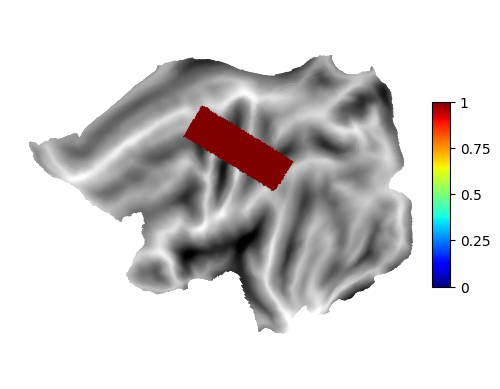

In [61]:
strip_ax = surf.plot.plotmap(data = virtual_stip_mask, 
                             surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                             colorbar = True, 
                             threshold = 0.0005)

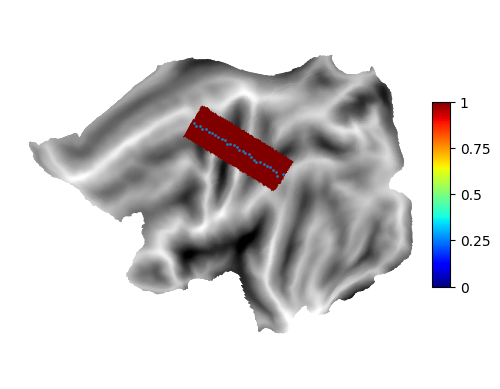

In [62]:
strip_ax.scatter(sampling_center_coords[:, 0], sampling_center_coords[:, 1], s = 1)
strip_ax.get_figure()

In [63]:
sampling_coverages_sum = np.array([np.where(e != 0, i/10, 0) for i, e in enumerate(sampling_coverages)]).T
sampling_coverages_sum = np.sum(sampling_coverages_sum, axis = 1)

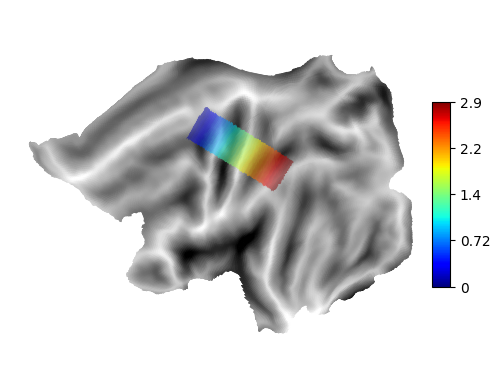

In [64]:
sampling_coverage_ax = surf.plot.plotmap(data = sampling_coverages_sum, 
                                         surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                                         colorbar = True, 
                                         threshold = 0.0001,
                                         alpha = 0.5)

# Non-smoothing

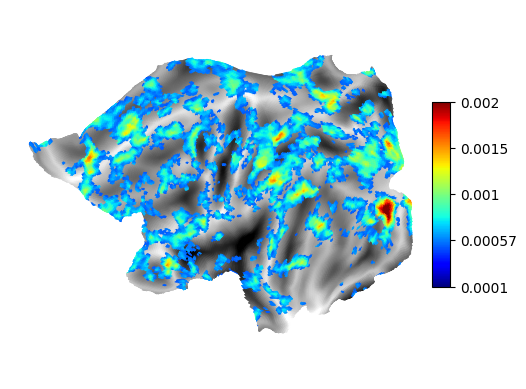

In [65]:
slightly_small_value = 0.0001

ax = surf.plot.plotmap(data = np.mean(surface_datas, axis = 1), 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005,
                       cscale = [slightly_small_value, 0.002])

# Smoothing

In [66]:
# Template vertex coordinates
temploate_surface_data = nb.load(template_surface_path)
vertex_locs = temploate_surface_data.darrays[0].data[:, :2]

# Data
mean_data = np.mean(surface_datas, axis = 1)
smoothed_data = gaussian_weighted_smoothing(coords = vertex_locs, 
                                            values = mean_data, 
                                            sigma = 2.0)

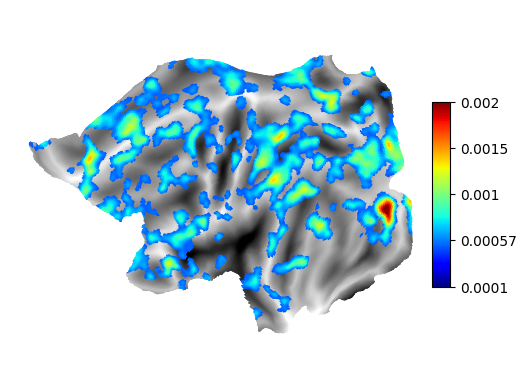

In [67]:
slightly_small_value = 0.0001

ax = surf.plot.plotmap(data = smoothed_data, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005,
                       cscale = [slightly_small_value, 0.002])

# Filter data only including in rectangle (from ~ to)

In [68]:
rect_vertexes = vertex_locs[np.where(virtual_stip_mask == 1, True, False)]
min_rect_x, max_rect_x = np.min(rect_vertexes[:, 0]), np.max(rect_vertexes[:, 0])
min_rect_y, max_rect_y = np.min(rect_vertexes[:, 1]), np.max(rect_vertexes[:, 1])
within_x = (vertex_locs[:, 0] >= min_rect_x) & (vertex_locs[:, 0] <= max_rect_x)
within_y = (vertex_locs[:, 1] >= min_rect_y) & (vertex_locs[:, 1] <= max_rect_y)
is_within_rectangle = np.logical_and(within_x, within_y)

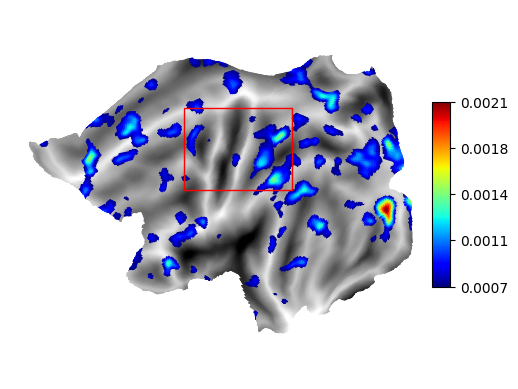

In [69]:
rect = Rectangle((min_rect_x, min_rect_y), max_rect_x - min_rect_x, max_rect_y - min_rect_y, linewidth=1, edgecolor='r', facecolor='none')
ax = surf.plot.plotmap(data = smoothed_data, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = patten_separation_threshold,
                       cscale = [patten_separation_threshold, np.max(smoothed_data)])
ax.add_patch(rect)

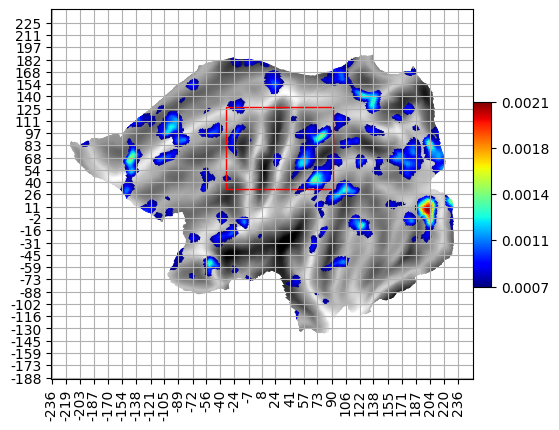

In [70]:
ax.grid(True)
ax.axis("on")
x_min, x_max = int(ax.get_xlim()[0]), int(ax.get_xlim()[1])
y_min, y_max = int(ax.get_ylim()[0]), int(ax.get_ylim()[1])

x_count = 30
y_count = 30
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)

ax.get_figure()

# Visualizaion

In [71]:
rect = Rectangle((min_rect_x, min_rect_y), max_rect_x - min_rect_x, max_rect_y - min_rect_y, linewidth=1, edgecolor='r', facecolor='none')
sampling_coverage_ax.add_patch(rect)

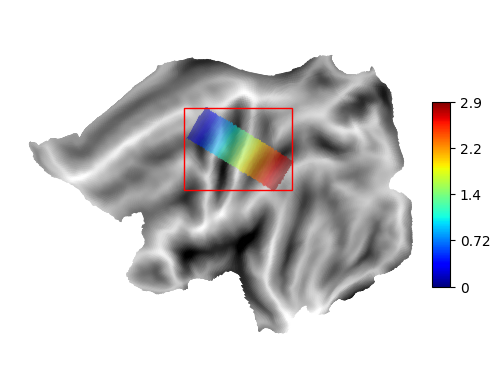

In [72]:
sampling_coverage_ax.get_figure()

In [73]:
from sj_visualization import plot_stats

In [74]:
tstats = ttest_1samp(sampling_datas, axis = 1, popmean = 0)

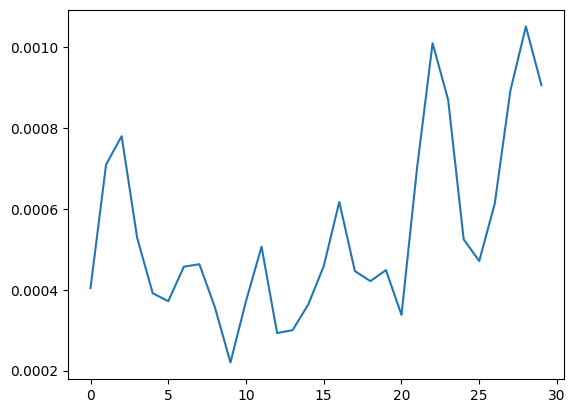

In [75]:
plt.plot(np.mean(sampling_datas, axis = 1))

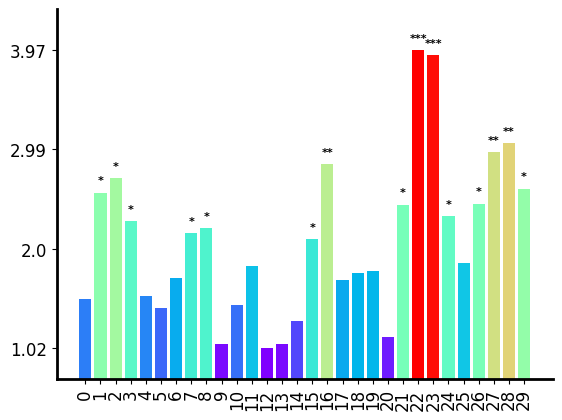

In [76]:
fig, axis = plt.subplots(1)
plot_stats(axis, 
           np.arange(0, cross_section_n_sampling), 
           tstats.statistic, 
           tstats.pvalue, 
           is_sort = False, 
           style_info = {"palette" : "rainbow"})
None

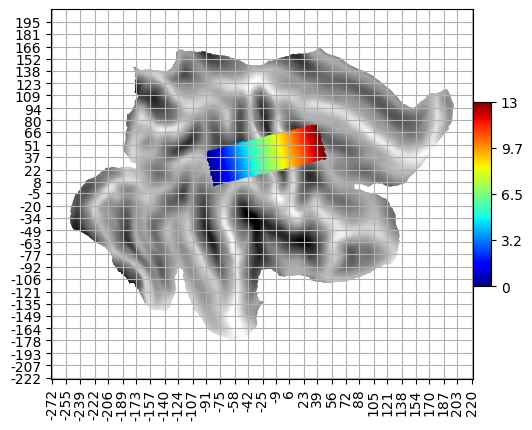

In [56]:
sampling_coverage_ax.get_figure()
sampling_coverage_ax.grid(True)
sampling_coverage_ax.axis("on")
x_min, x_max = int(sampling_coverage_ax.get_xlim()[0]), int(sampling_coverage_ax.get_xlim()[1])
y_min, y_max = int(sampling_coverage_ax.get_ylim()[0]), int(sampling_coverage_ax.get_ylim()[1])

x_count = 30
y_count = 30
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
sampling_coverage_ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
sampling_coverage_ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

sampling_coverage_ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
sampling_coverage_ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)

sampling_coverage_ax.get_figure()


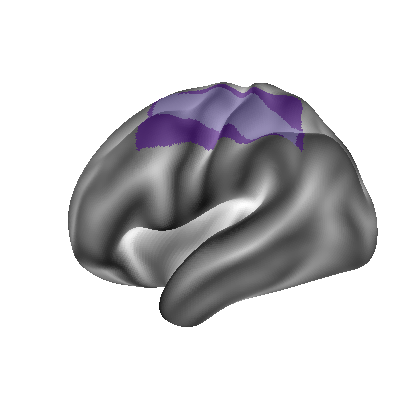

In [103]:
fig = plot_surf_roi(surf_mesh = inflated_brain_path,
                    roi_map = np.where(virtual_stip_mask, 0.7, np.where(is_within_rectangle, 1, 0)),
                    bg_map = shape_gii_path,
                    hemi = "left" if surf_hemisphere == "L" else "right",
                    cmap='Purples',
                    alpha = 2, 
                    vmax = 1, # 1.4, 3
                    bg_on_data = True,
                    darkness = 1.0
)

- 